In [1]:
from numba import float32,int32,int8,jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32,xoroshiro128p_uniform_float64
from numba.cuda.random import xoroshiro128p_normal_float32
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from util import *
import torch
from torch import nn

# Using the decompression functions from data generation

In [2]:
@cuda.jit
def decompress2D(inn,states):
    """Inverse function of compress"""
    sz,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        state[x][y]=1&(num>>bit)

@cuda.jit
def decompress1D(inn,states):
    """Similar to decompress 2D but instead of being an inverse to compress it squishes the 2D
    array output into a 1D array (which is now in a snake pattern)
    if states has shape [N,X,1] then out should have shape [M,Z/8]
    and the blocks/threads should have shape [N,Z/8]
    Here Z=X*Y where each state has shape [X,Y] on a 2D grid
    
    Note: This is slightly changed to work with the correct tensor shape
    """
    #n is which grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        #get each value in 1d
        state[idx][0]=1&(num>>bit)

In [3]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


# Implementing a simple RNN model

In [4]:
class RNN(nn.Module):
    def __init__(self,device=device, **kwargs):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=1,hidden_size=128,batch_first=True)
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        self.device=device
        self.to(device)
    def forward(self, input):
        # h0 has shape [N,L,H]
        h0=torch.zeros([1,input.shape[0],128]).to(device)
        out,h=self.rnn(input,h0)
        return self.lin(out)

In [5]:
traindata = np.load('data/traindata32-4407.npy')

In [6]:
traindata = traindata[np.random.permutation(traindata.shape[0])]
traindata.shape

(51200000, 128)

# Making sure the shape of everything lines up

In [7]:

#bsize=2048
#N=16

bsize=1024
N=32

batch=torch.zeros([bsize,N*N,1]).to(device)
decompress1D[(bsize,N//2),(1,N//4)](traindata[0:bsize],batch)
data=batch[:,:-1,:]
label=batch[:,1:,:]
print(data.shape,label.shape)
print(data[:,:,0])

torch.Size([1024, 1023, 1]) torch.Size([1024, 1023, 1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')


In [8]:
#initialize the network
net=RNN()

print(net(data).shape)
#training parameters
lr = 1e-4
if bsize<2048:lr/=2
beta1 = 0.9
beta2=0.999
#Using adam to optimize
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)

torch.Size([1024, 1023, 1])


# Make sure to use a loss which will give you probabilities in your predictions.

I know L2 loss and Binary Cross Entropy Loss will do this

In [9]:
Loss = nn.BCELoss()
losses=[]
validation=[]
vidx= traindata.shape[0]//bsize-1
print(vidx)

49999


# Network actually trains in a few epochs

In [10]:
epoch=3

#set the last batch to validation
#this is a super lazy validation set 

count=0
for i in range(epoch):
    #decided the last batch is validation 
    p = np.random.permutation(traindata.shape[0]//bsize)
    t=time.time()
    for idx in p:
        #decompress the traindata with the gpu
        decompress1D[(bsize,N//2),(1,N//4)](traindata[bsize*idx:bsize*(idx+1)],batch)
        #starting N**2-1 are inputs
        data=batch[:,:-1,:]
        #ending N**2-1 are predictions
        real=batch[:,1:,:]
        
        pred = net(data)
        loss = Loss(pred,real)
        net.zero_grad()
        if idx!=vidx:
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
        else:
            validation.append(loss.cpu().item())
        count+=1
        if (count%500)==0:
            print("|",end="")
    if epoch//100==0 or i%(epoch//100)==0:
        print("%.5f, %ds"%(np.mean(losses[-p.size-1:]),time.time()-t),end="| ")
        torch.save(net,"models/32-4407-%d"%i)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||0.34015, 2497s| ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||0.33514, 2498s| ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||0.33041, 2493s| 

# Plotting training loss

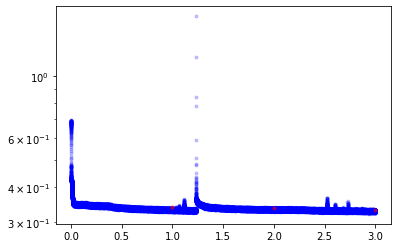

In [11]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()

# Testing Our Output

In [12]:
testdata=np.load('data/testdata32.npy')

In [13]:
testdata.shape
with torch.no_grad():
    print('yay')

yay


# Computing True and Predicted Energies

Note: To go from probability to energy we look at the relation:

$P(s)=\frac{exp(-\beta H(s))}{Z} = \frac{1}{2} \prod_{i=2}^{N^2}p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1) $

So

$ln(P(s)) = -\beta H(s) - ln(Z) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]$

$-\beta H(s) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]+ln(Z)$

$H(s) = \frac{ln(2)- \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]}{\beta }-\frac{ln(Z)}{\beta}$

In [14]:
@cuda.jit
def IsingEnergy(grids,E):
    """Compute Energy of 2D ising lattice (J=1 h=0)"""
    z,i,j=cuda.grid(3)
    sz,sx,sy=grids.shape
    s1=grids[z][i][j]*2-1
    s2=grids[z][(i+1)%sx][j]*2-1
    s3=grids[z][i][(j+1)%sy]*2-1
    cuda.atomic.add(E,z,-s1*s2-s1*s3)

def trueEnergies(grids,N):
    """Compute the true energies of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],N,N]).to(device)
    decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    E=np.zeros(grids.shape[0])
    IsingEnergy[(grids.shape[0],N//8,N//8),(1,8,8)](testbatch,E)
    return E

def logprobability(grids,N):
    """compute the logscale probability of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],N*N,1]).to(device)
    decompress1D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    data=testbatch[:,:-1,:]
    real=testbatch[:,1:,:]
    #real is going to be a set of actual values
    #and pred is going to be a set of probabilities
    #if real[i]=1 than you muptiply your conditional probability by pred[i]
    #if real[i]=0 than you muliply by 1-pred[i]
    with torch.no_grad():
        pred = net(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
    #this is the sum you see in the cell above
    logp=torch.sum(torch.log(total),dim=1).squeeze(1)-np.log(2)
    return logp
    


# Looking at performance on our validation set

Note: The validation set has the same distribution of states as the training set

tensor(771.0453) -1461.09375 tensor(2232.1392)


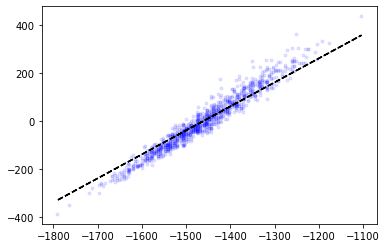

In [15]:
prob = logprobability(traindata[bsize*vidx:bsize*(vidx+1)],N)
trueE = trueEnergies(traindata[bsize*vidx:bsize*(vidx+1)],N)

relE=-prob.cpu()/0.4407
print(relE.mean(),trueE.mean(),relE.mean()-trueE.mean())
off=relE.mean()-trueE.mean()
plt.plot(trueE,relE-relE.mean(),'.',color=(0,0,1,0.1))
plt.plot(trueE,trueE-trueE.mean(),'k--')

# Looking at performance on our test set

Note: The test set has a very different distribution than our training set: States with energy zero and above will never actually have been seen by our network

tensor(1955.0851)


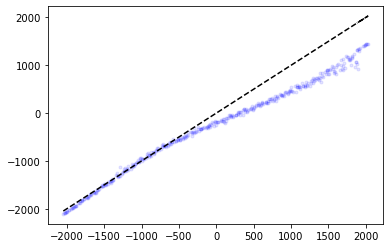

In [16]:
probB = logprobability(testdata[::100].copy(),N)
trueEB = trueEnergies(testdata[::100].copy(),N)

relEB=-probB.cpu()/0.4407

print(relEB.mean())
plt.plot(trueEB,relEB-off,'.',color=(0,0,1,0.1))
plt.plot(trueEB,trueEB,'k--')

In [21]:
net = torch.load("models/32-4407-3")
#net = torch.load("32-4407-U")